<a href="https://colab.research.google.com/github/BRIAN12682/Automation-Projects/blob/main/NLPMalaria3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import os
import xml.etree.ElementTree as ET
from PIL import Image, UnidentifiedImageError
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class MalariaDataset(Dataset):
    def __init__(self, annotations_dir, images_dir, transform=None):
        self.annotations_dir = annotations_dir
        self.images_dir = images_dir
        self.transform = transform
        self.data = self._load_data()

    def _load_data(self):
        annotations = []
        for class_folder in ['Positive', 'Negative']:
            class_path = os.path.join(self.images_dir, class_folder)
            for img_file in os.listdir(class_path):
                if img_file.endswith('.jpg'):
                    filename = img_file
                    xml_file = os.path.splitext(filename)[0] + ".xml"
                    xml_path = os.path.join(self.annotations_dir, xml_file)
                    try:
                        tree = ET.parse(xml_path)
                        root = tree.getroot()

                        boxes = []
                        for obj in root.findall('object'):
                            bbox = obj.find('bndbox')
                            if bbox is not None:
                                xmin = float(bbox.find('xmin').text)
                                ymin = float(bbox.find('ymin').text)
                                xmax = float(bbox.find('xmax').text)
                                ymax = float(bbox.find('ymax').text)
                                boxes.append([xmin, ymin, xmax, ymax])
                        annotations.append({'filename': os.path.join(class_folder, filename), 'boxes': boxes})
                    except ET.ParseError as e:
                        print(f"Error parsing {xml_file}: {e}")
                    except FileNotFoundError:
                        # For negative class, there might not be an xml file
                        if class_folder == 'negative':
                            annotations.append({'filename': os.path.join(class_folder, filename), 'boxes': []})
        return annotations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = os.path.join(self.images_dir, item['filename'])
        try:
            image = Image.open(image_path).convert('RGB')
        except (UnidentifiedImageError, FileNotFoundError) as e:
            print(f"Error loading image {image_path}: {e}")
            return self.__getitem__((idx + 1) % len(self.data))  # Try the next item
        if self.transform:
            image = self.transform(image)
        boxes = item['boxes']
        num_pathogens = len(boxes)
        if num_pathogens == 0:
            caption = "This image shows no pathogens and is not infected."
        elif num_pathogens > 5:
            caption = f"This image shows {num_pathogens} pathogens and is severely infected."
        else:
            caption = f"This image shows {num_pathogens} pathogens and is moderately infected."
        return image, caption

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Paths to datasets and annotations
train_images_dir = '/content/drive/MyDrive/Organised_Annotated_Folder'
val_images_dir = '/content/drive/MyDrive/DATASETS/Annotated_Folder/train'
annotations_dir = '/content/drive/MyDrive/DATASETS/MalariaPI/annotation'

# Load datasets
train_dataset = MalariaDataset(annotations_dir, train_images_dir, transform=transform)
val_dataset = MalariaDataset(annotations_dir, val_images_dir, transform=transform)

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [19]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 2679
Number of validation samples: 2187


In [2]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, GPT2Tokenizer
import torch
# Initialize the tokenizer and processor first
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set padding token

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# Initialize the model
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.eos_token_id

# Enable gradient checkpointing for more memory efficient training
model.encoder.gradient_checkpointing_enable()
model.decoder.gradient_checkpointing_enable()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [9]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.21.0
    Uninstalling accelerate-0.21.0:
      Successfully uninstalled accelerate-0.21.0


In [12]:
!pip install transformers[torch]

In [20]:
import torch
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    fp16=True,
    output_dir="./results",
    logging_steps=10,
    save_steps=10,
    eval_steps=10,
    num_train_epochs=0.3,
    save_total_limit=2,
)

# Custom collate function to handle varying-length captions
def collate_fn(batch):
    images, captions = zip(*batch)
    pixel_values = processor(images=images, return_tensors="pt", do_rescale=False).pixel_values  # Ensure no rescaling
    captions = list(captions)
    tokenized_captions = tokenizer(captions, padding="max_length", truncation=True, return_tensors="pt")
    labels = tokenized_captions.input_ids
    labels[labels == tokenizer.pad_token_id] = -100
    return {"pixel_values": pixel_values, "labels": labels}

# Initialize Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    tokenizer=tokenizer,
)

# Train the model
trainer.train()
# Evaluate the model
results = trainer.evaluate()
validation_accuracy = results["eval_accuracy"]

# Save the model and tokenizer
model.save_pretrained("/content/drive/MyDrive/vitgpt_model")
tokenizer.save_pretrained("/content/drive/MyDrive/vitgpt_model")

# Save the validation accuracy
with open("/content/drive/MyDrive/validation_accuracy.txt", "w") as f:
    f.write(f"Validation Accuracy: {validation_accuracy}\n")


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
10,0.735900,0.501012
20,0.552000,0.482062
30,0.377200,0.345352
40,0.417900,0.379135
50,0.327600,0.328134
60,0.444900,0.348118
70,0.371900,0.285912
80,0.326300,0.281261
90,0.256100,0.310717
100,0.351100,0.268154


Error loading image /content/drive/MyDrive/DATASETS/Annotated_Folder/train/Positive/plasmodium-2137.jpg: cannot identify image file '/content/drive/MyDrive/DATASETS/Annotated_Folder/train/Positive/plasmodium-2137.jpg'
Error loading image /content/drive/MyDrive/DATASETS/Annotated_Folder/train/Positive/plasmodium-2137.jpg: cannot identify image file '/content/drive/MyDrive/DATASETS/Annotated_Folder/train/Positive/plasmodium-2137.jpg'
Error loading image /content/drive/MyDrive/DATASETS/Annotated_Folder/train/Positive/plasmodium-2137.jpg: cannot identify image file '/content/drive/MyDrive/DATASETS/Annotated_Folder/train/Positive/plasmodium-2137.jpg'
Error loading image /content/drive/MyDrive/DATASETS/Annotated_Folder/train/Positive/plasmodium-2137.jpg: cannot identify image file '/content/drive/MyDrive/DATASETS/Annotated_Folder/train/Positive/plasmodium-2137.jpg'
Error loading image /content/drive/MyDrive/DATASETS/Annotated_Folder/train/Positive/plasmodium-2137.jpg: cannot identify image f

Error loading image /content/drive/MyDrive/DATASETS/Annotated_Folder/train/Positive/plasmodium-2137.jpg: cannot identify image file '/content/drive/MyDrive/DATASETS/Annotated_Folder/train/Positive/plasmodium-2137.jpg'


KeyError: 'eval_accuracy'

In [46]:
# Directory to save the model and tokenizer
output_dir ="/content/drive/MyDrive/vitgpt_model"

# Save the model
model.save_pretrained(output_dir)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

# Save the processor (ViT image processor)
processor.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")


Model and tokenizer saved to /content/drive/MyDrive/vitgpt_model


In [22]:

# Save the model and tokenizer
model.save_pretrained("/content/drive/MyDrive/vitgpt_model")
tokenizer.save_pretrained("/content/drive/MyDrive/vitgpt_model")

# # Save the validation accuracy
# with open("/content/drive/MyDrive/validation_accuracy.txt", "w") as f:
#     f.write(f"Validation Accuracy: {validation_accuracy}\n")


('/content/drive/MyDrive/vitgpt_model/tokenizer_config.json',
 '/content/drive/MyDrive/vitgpt_model/special_tokens_map.json',
 '/content/drive/MyDrive/vitgpt_model/vocab.json',
 '/content/drive/MyDrive/vitgpt_model/merges.txt',
 '/content/drive/MyDrive/vitgpt_model/added_tokens.json')

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


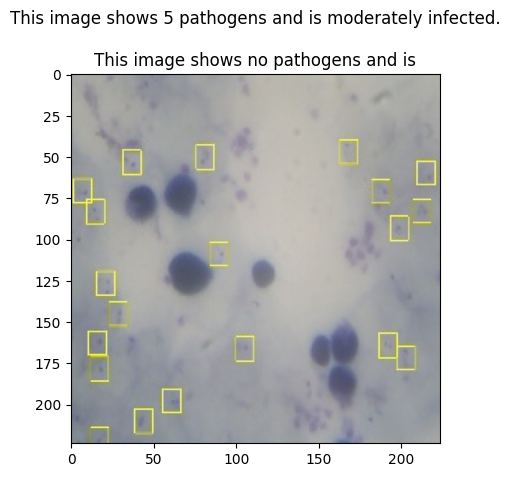

In [30]:
import matplotlib.pyplot as plt

def predict_and_visualize(image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    pixel_values = processor(images=[image], return_tensors="pt", do_rescale=False).pixel_values.to(device)
    output_ids = model.generate(pixel_values)
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    plt.imshow(image)
    plt.title(caption)
    plt.show()

# Example usage
test_image_path = '/content/drive/MyDrive/DATASETS/Annotated_Folder/train/Positive/plasmodium-0000.jpg'
predict_and_visualize(test_image_path)


Caption: This image shows 22 pathogens and is severely infected.
This image shows 23 pathogens and is severely


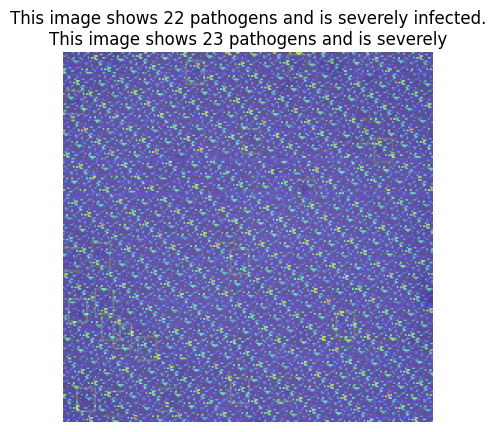

In [37]:
import numpy as np# Add this function after defining your model and other necessary components
def visualize_attention(image_path, model, tokenizer, processor):
    # Load and process the image
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    # Get the hidden states and attentions from the encoder
    model.eval()
    with torch.no_grad():
        encoder_outputs = model.encoder(**inputs, output_attentions=True, return_dict=True)

    # Decode the generated caption
    pixel_values = inputs["pixel_values"]
    generated_ids = model.generate(pixel_values)
    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print(f"Caption: {caption}")

    # Extract the attention weights
    encoder_attentions = encoder_outputs.attentions
    last_layer_attentions = encoder_attentions[-1]

    # Average the attention weights over all heads
    attn_weights = last_layer_attentions.mean(dim=1).squeeze().cpu().numpy()

    # Normalize the attention map
    attn_map = (attn_weights - attn_weights.min()) / (attn_weights.max() - attn_weights.min())

    # Resize the attention map to match the image size
    attn_map = np.resize(attn_map, (image.size[1], image.size[0]))

    # Overlay the attention map on the original image
    plt.imshow(image)
    plt.imshow(attn_map, cmap="jet", alpha=0.5)  # Adjust the alpha value to control transparency
    plt.axis("off")
    plt.title(caption)
    plt.show()

# Example usage
test_image_path = '/content/drive/MyDrive/DATASETS/Annotated_Folder/train/Positive/plasmodium-0003.jpg'
visualize_attention(test_image_path, model, tokenizer, processor)


In [41]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [43]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=f9b5960ee57be3247a05f1cdb030086d2bf71e9d6dbdbe2f69614c5afae4d372
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [3]:
from transformers import VisionEncoderDecoderModel, GPT2Tokenizer, ViTImageProcessor
import torch

# Directory where the model, tokenizer, and processor are saved
output_dir = "/content/drive/MyDrive/vitgpt_model"


# Load the model, tokenizer, and processor
model = VisionEncoderDecoderModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
processor = ViTImageProcessor.from_pretrained(output_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [7]:
from IPython.display import clear_output
!pip install datasets
!pip install rouge_score
clear_output()

In [8]:
from datasets import load_metric
import numpy as np

# Define evaluation metrics
bleu = load_metric("bleu")
rouge = load_metric("rouge")
meteor = load_metric("meteor")
# cider = load_metric("cider")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    bleu_score = bleu.compute(predictions=pred_str, references=label_str)
    rouge_score = rouge.compute(predictions=pred_str, references=label_str)
    meteor_score = meteor.compute(predictions=pred_str, references=label_str)
    cider_score = cider.compute(predictions=pred_str, references=label_str)

    return {
        "bleu": bleu_score["score"],
        "rouge": rouge_score["rougeL"].mid.fmeasure,
        "meteor": meteor_score["meteor"],
        # "cider": cider_score["CIDEr"]
    }


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major r

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
